### Table of Contents

1. [Data Preparation](#knn_dataprep)
2. [Default KNN Model](#1stmodel_knn)
3. [KNN Model with cross-validated Grid Search - Version 1](#2ndmodel_knn)
4. [KNN Modewl with cross-validated Grid Search - Version 2](#3rdmodel_knn)

### Data Preparation <a id='knn_dataprep'></a>

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from sklearn.dummy import DummyClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [59]:
def plot_roc_curve(test, model_probs, naive_probs):
    fpr, tpr, _ = roc_curve(test, naive_probs)
    plt.plot(fpr, tpr, linestyle = '--', label = 'Baseline')
    fpr, tpr, _ = roc_curve(test, model_probs)
    plt.plot(fpr, tpr, marker = '.', label = 'KNN Model', markersize = 0.1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title('ROC Curve')
    plt.show()
    
def plot_pr_curve(test, model_probs):
    no_skill = len(test[test == 1]) / len(test)
    
    plt.plot( [no_skill, no_skill], linestyle = '--', label = 'Baseline')
    
    precision, recall, _ = precision_recall_curve(test, model_probs)
    plt.plot(recall, precision, marker = '.', label = 'KNN Model', markersize = 0.1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision - Recall Curve')
    plt.legend()
    plt.show()

#### Setting Up Data

In [2]:
#Reading in data with random forest selected features
df = pd.read_csv('../data/loan_rf_features.csv')

In [10]:
#Setting up X and y
X = pd.get_dummies(df.drop(columns = ['loan_status']))
y = df['loan_status']

In [11]:
#Train, test, split with scaling
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y,
                                                    test_size= 0.2)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [45]:
#Baseline Model
dummy_model = DummyClassifier(strategy= 'stratified')
dummy_model.fit(X_train, y_train)
naive_preds = dummy_model.predict_proba(X_test)[:, 1]

### Default K-Nearest Neighbors Model <a id='1stmodel_knn'></a>

In [12]:
#Instantiating and fitting model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

In [14]:
#Training data accuracy score
knn.score(X_train, y_train)  

0.913332411273882

In [15]:
#Testing Data accuracy score
knn.score(X_test, y_test)

0.8779319595910603

### K-Nearest Neighbors with GridSearch CV - Version 1 <a id='2ndmodel_knn'></a>

In [18]:
#Instantiating model and fitting using specified KNN parameters
knn_params = {
    'n_neighbors' : [3, 10],
    'metric'     : ['euclidean', 'manhattan']
}

knn_gs = GridSearchCV(KNeighborsClassifier(),
                      param_grid = knn_params,
                      cv = 3,
                      verbose = 2,
                      n_jobs = -1)

knn_gs.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\eddie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 10]},
             verbose=2)

In [20]:
#Best Parameters
knn_gs.best_params_

{'metric': 'euclidean', 'n_neighbors': 3}

In [22]:
#Testing data accuracy score
knn_gs.score(X_test, y_test)

0.8707020030162712

In [24]:
#Generating predicted probabilities
knn_test_probs = knn_gs.predict_proba(X_test)[:, 1]

In [61]:
#Generating relevant curves and evaluation metrics
plot_roc_curve(y_test, knn_test_probs, naive_preds)
plot_pr_curve(y_test, knn_test_probs)

print(f'Testing Data ROC-AUC score KNN (Best Parameters + Feature Selection): {roc_auc_score(y_test, knn_test_probs):.3f}')

precision, recall, _ = precision_recall_curve(y_test, knn_test_probs)
print(f'Testing Data PR-AUC score KNN (GridSearch CV): {auc(recall, precision):.3f}')

NameError: name 'knn_test_probns' is not defined

### K-Nearest Neighbors with GridSearch CV - Version 2 <a id='3rdmodel_knn'></a>

In [35]:
#Instantiating model and fitting using specified KNN parameters
knn_params = {
    'n_neighbors' : [2, 5, 10],
    'weights'     : ['uniform', 'distance']
}

knn_gs_2 = GridSearchCV(KNeighborsClassifier(),
                      param_grid = knn_params,
                      cv = 3,
                      verbose = 2,
                      n_jobs = -1)

knn_gs_2.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\eddie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan 0.88189555]
  warnings.warn(


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 5, 10],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [48]:
#Best parameters from second grid search
knn_gs_2.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

In [36]:
#Generating predictions
y_preds = knn_gs_2.predict(X_test)
y_preds_probs= knn_gs_2.predict_proba(X_test)


In [ ]:
knn_probs = pd.DataFrame(y_preds_probs, columns = ['knn_probs'])
knn_probs.to_csv('../data/knn_probs.csv')

In [52]:
#Recall Score for second GridSearchCV
recall_score(y_test, y_preds)

0.563449840779513

In [53]:
#Precision Score for second GridSearchCV
precision_score(y_test, y_preds)

0.7860658136256019

In [54]:
#Accuracy Score for second GridSearchCV
accuracy_score(y_test, y_preds)

0.8827746663534191

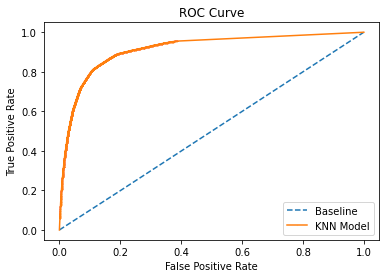

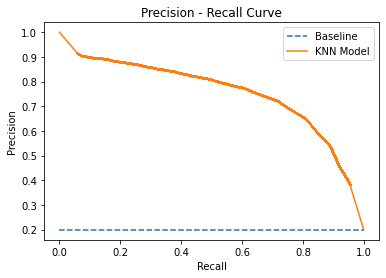

Testing Data ROC-AUC score KNN (Best Parameters + Feature Selection): 0.915
Testing Data PR-AUC score KNN (GridSearch CV): 0.757


In [60]:
#Generating relevant curves and evaluation metrics
plot_roc_curve(y_test, y_preds_probs, naive_preds)
plot_pr_curve(y_test, y_preds_probs)

print(f'Testing Data ROC-AUC score KNN (Best Parameters + Feature Selection): {roc_auc_score(y_test, y_preds_probs):.3f}')

precision, recall, _ = precision_recall_curve(y_test, y_preds_probs)
print(f'Testing Data PR-AUC score KNN (GridSearch CV): {auc(recall, precision):.3f}')